In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
# if CUDA is available, use GPU and set default tensor type to cuda

'''
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass
'''    


'\nif torch.cuda.is_available():\n    torch.set_default_tensor_type(torch.cuda.FloatTensor)\n    print("using cuda:", torch.cuda.get_device_name(0))\n    pass\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\ndevice\n\nfrom multiprocessing import set_start_method\ntry:\n    set_start_method(\'spawn\')\nexcept RuntimeError:\n    pass\n'

In [3]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
             
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        
        return sample, label

In [4]:
real_data = pandas.read_csv('dataset/qm9.csv')
max_alpha = max(real_data['alpha'])
min_alpha = min(real_data['alpha'])
number_of_data = len(real_data)

print("number_of_data", number_of_data, "max_alpha", max_alpha, "min_alpha", min_alpha)
real_data.head(5)

number_of_data 133885 max_alpha 196.62 min_alpha 6.31


,smiles,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298
0,C,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,6.469,-40.478930,-40.476062,-40.475117,-40.498597
1,N,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,6.316,-56.525887,-56.523026,-56.522082,-56.544961
2,O,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,6.002,-76.404702,-76.401867,-76.400922,-76.422349
3,C#C,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,8.574,-77.308427,-77.305527,-77.304583,-77.327429
4,C#N,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,6.278,-93.411888,-93.409370,-93.408425,-93.431246


In [5]:
data = pandas.read_csv('dataset/GDB13_Subset-ABCDEFGH.smi', header=None, names=["smiles"])
data.head(5)


,smiles
0,S1C=CC=C1
1,O1C=CC=C1
2,C1CCCC1
3,N1C=CC=C1
4,S1C=CC=N1


,smiles,Molecule
0,S1C=CC=C1,

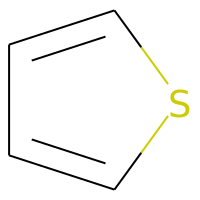

In [6]:
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
data = data[0:number_of_data]
data[["smiles","Molecule"]].head(1)


In [7]:
data['smiles'].iloc[10]

'ClC1=CSC=C1'

In [8]:
PandasTools.AddMoleculeColumnToFrame(real_data,'smiles','Molecule')
real_data[["smiles","Molecule"]].head(1)
len(real_data)

133885

In [9]:
from molvecgen.vectorizers import SmilesVectorizer

smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(real_data.Molecule.values, )

In [10]:
smivec_data = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec_data.fit(data.Molecule.values, )

In [11]:
# functions to generate random data

def generate_random_seed_G(size):
    random_data = torch.randn(size)
    return random_data


def generate_random_value(size):
    random_data = torch.round(torch.randn(size) * 10000) / 100
    #round(random.uniform(min_alpha, max_alpha),2)
    return random_data

In [12]:
'''
y = real_data.alpha.values.reshape((-1,1))
X = real_data.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)

#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

print('len(X_train)',len(X_train), 'X_train.shape', X_train.shape)
'''

y = real_data.alpha.values.reshape((-1,1))
X = real_data.Molecule.values

#Normalizing output using standard scaling
scaler = StandardScaler()
X_train = X
y_train = scaler.fit_transform(y)

print('len(X_train)',len(X_train), 'X_train.shape', X_train.shape)



len(X_train) 133885 X_train.shape (133885,)


In [13]:
data_y = generate_random_value(number_of_data).reshape((-1,1))
data_X = data.Molecule.values
scaler = StandardScaler()
data_y = scaler.fit_transform(data_y)
data_dataset = SMILESMolDataset(data_X, data_y, smivec_data)
print('data_dataset[10]', data_dataset[10], 'len(data_dataset[10][0])', len(data_dataset[10][0]) )


data_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
   

In [14]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[10]
print('train_dataset[10]', train_dataset[10], 'len(train_dataset[10][0])', len(train_dataset[10][0]) )

train_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
  

In [15]:
# return a random SMILES from the GDB13_Subset
def generate_random_seed():
    random_data = data_dataset[random.randint(0, number_of_data)]
    #random_data = data_dataset[10]
    return random_data

generate_random_seed()

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0],

In [16]:
epochs = 1
dims = smivec.dims
lstm_size = 128  # The size of the LSTM layer
hidden_size = 128  # The size of the hidden non-linear layer
dropout_rate = 0.50 # The dropout rate
out_size = 1        # This is just a single task, so this will be one
#batch_size = 128   # The mini_batch size during training
batch_size = 1   # The mini_batch size during training
learning_rate = 0.003  # The initial learning rate for the optimizer

In [25]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        length = dims[0] 
        number_tokens = dims[1] + 1  # add the label layer
        #print('LSTM input_size', number_tokens)
         
        
        self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)       
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.lr_scheduler = ReduceLROnPlateau(self.optimiser, mode='min', factor=0.5, patience=50, 
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, input, label_tensor):
        # combine seed and label
        
        
        #print("input.shape", input.shape, "label_tensor.shape", label_tensor.shape)
        x = torch.cat((input, label_tensor), -1)
        #print('after torch.cat', x.shape)
        
        
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out
    
    
    def train(self, inputs, label_tensor, targets):
        # calculate the output of the network
        outputs = self.forward(inputs, label_tensor)
        
        
        #print('outputs', outputs)
        #print('targets', targets)
        # calculate loss
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [26]:
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers=4)



In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
%%time
# test discriminator can separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label in data_loader:
    # real
    t = torch.FloatTensor([1.0]).view(1,1,1).to(device)
    label = label.float().to(device)
    label = label.repeat(smiles.shape[0], smiles.shape[1], 1)
    D.train(smiles.to(device).float(), label, t)

    # fake
    fake = generate_random_seed()
    fake_input = torch.FloatTensor(fake[0]).to(device)
    fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake[1]).to(device)
    fake_label = fake_label.repeat(smiles.shape[0], smiles.shape[1], 1)
    D.train(fake_input, fake_label, torch.FloatTensor([0.0]).to(device)  )
    pass

counter =  10000


KeyboardInterrupt: 

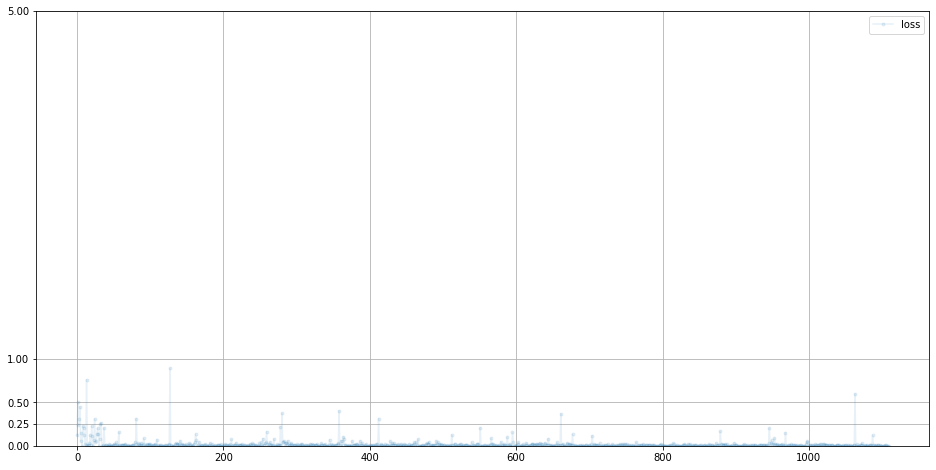

In [24]:
D.plot_progress()

In [25]:
'''
for i in range(4):
    #random.randint(0,20000)
    data_tensor,_,_ = qm9dataset[random.randint(0,130000)]
    print( D.forward( data_tensor ).item() )
    pass

for i in range(4):
    print( D.forward(generate_random_smiles(max_length_smiles)).item() )
    pass



D = Discriminator()
D.to(device)
'''


i = 0
for smiles,label in data_loader:
    # real
    t = torch.FloatTensor([1.0]).view(1,1,1).to(device)
    label = label.float().to(device)
    label = label.repeat(smiles.shape[0], smiles.shape[1], 1)
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 4):
        break
    pass

for i in range(4):
    fake = generate_random_seed()
    fake_input = torch.FloatTensor(fake[0]).to(device)
    fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake[1]).to(device)
    fake_label = fake_label.repeat(smiles.shape[0], smiles.shape[1], 1)
    print( D.forward(fake_input, fake_label))
    pass


tensor([[[0.9721]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[1.0488]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.3684]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[1.1044]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.0913]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.0408]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.0139]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.0537]]], device='cuda:0', grad_fn=<AddBackward0>)


In [72]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(2,1000),
            nn.Sigmoid(),
            nn.Linear(1000,number_of_data)
            #nn.Softmax(dim = 1)
        )
        
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        #print('input.shape', seed_tensor.shape, 'label_tensor', label_tensor.shape, "label_tensor", label_tensor)
        inputs = torch.cat((seed_tensor, label_tensor))
        #print('after torch.cat', inputs.shape)
        return F.softmax(self.model(inputs), dim=0)


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)
        
        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def get_index(self, tensor_softmax):
        return torch.argmax(tensor_softmax)

    def get_smiles(self, label):
        fake_input = torch.FloatTensor(generate_random_seed_G(1)).to(device)
        fake_label = torch.FloatTensor([label]).to(device)
        
        idx = self.get_index(G.forward(fake_input, fake_label)).detach().cpu().numpy()
        print(data['smiles'].iloc[idx])
        pass

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [73]:
# check the generator output is of the right type and shape

G = Generator()
G.to(device)

#fake = generate_random_seed()
fake_input = torch.FloatTensor(generate_random_seed_G(1)).to(device)
fake_label = torch.FloatTensor(generate_random_value(1).reshape(1)).to(device)
idx = torch.argmax(G.forward(fake_input, fake_label))
data_dataset[idx]



(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],

In [76]:
G.get_smiles(-12.2323)

N1C=NC(=C1)C1=NC=CN=C1


In [ ]:
%%time 

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

# train Discriminator and Generator

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label in data_loader:
        # train discriminator on true
        t = torch.FloatTensor([1.0]).view(1,1,1).to(device)
        label = label.float().to(device)
        label = label.repeat(smiles.shape[0], smiles.shape[1], 1)
        D.train(smiles.to(device).float(), label, t)
        
        
        # train discriminator on false
        # use detach() so gradients in G are not calculated
        fake_input = torch.FloatTensor(generate_random_seed_G(1)).to(device)
        fake_label = torch.FloatTensor(generate_random_value(1).reshape(1)).to(device)
        data_inx = torch.argmax(G.forward(fake_input, fake_label).detach())
        #print("data_inx", data_inx)
        
        fake = data_dataset[data_inx]
        #print('fake', fake)
        
        fake_input = torch.FloatTensor(fake[0]).to(device)
        fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
        fake_label = torch.FloatTensor(fake[1]).to(device)
        fake_label = fake_label.repeat(smiles.shape[0], smiles.shape[1], 1)
        D.train(fake_input, fake_label, torch.FloatTensor([0.0]).to(device)  )
        
    
    
        # train generator
        #fake_input = torch.FloatTensor(generate_random_seed_G(1)).to(device)
        #fake_label = torch.FloatTensor(generate_random_value(1).reshape(1)).to(device)
        #G.train(D, fake_input, fake_label, torch.FloatTensor([1.0]))

    pass
    
pass


epoch =  1


/home/tony/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


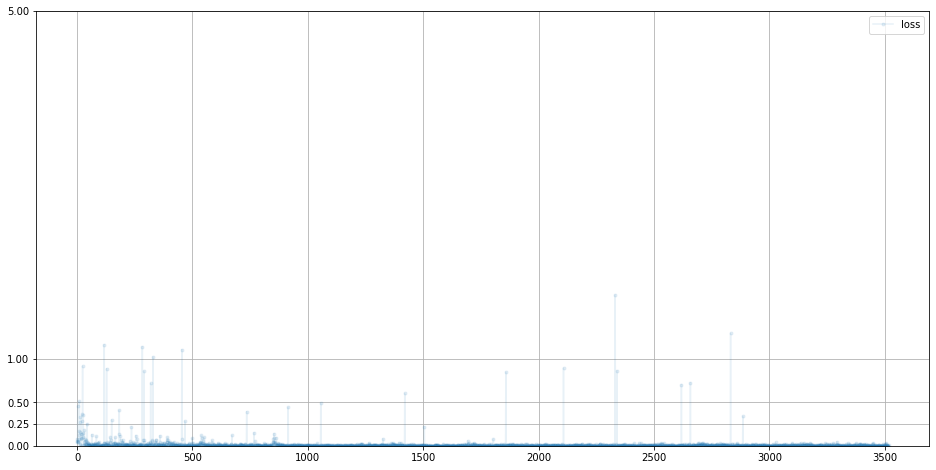

In [27]:
D.plot_progress()

In [29]:
i = 0
for smiles,label in data_loader:
    # real
    t = torch.FloatTensor([1.0]).view(1,1,1).to(device)
    label = label.float().to(device)
    label = label.repeat(smiles.shape[0], smiles.shape[1], 1)
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 4):
        break
    pass

for i in range(4):
    fake = generate_random_seed()
    fake_input = torch.FloatTensor(fake[0]).to(device)
    fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake[1]).to(device)
    fake_label = fake_label.repeat(smiles.shape[0], smiles.shape[1], 1)
    print( D.forward(fake_input, fake_label))
    pass

tensor([[[0.8938]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.9498]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[1.0080]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[1.0399]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.1738]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.9187]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.0274]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[0.0228]]], device='cuda:0', grad_fn=<AddBackward0>)
